# 🧭 **Gun Detection — Dataset, Model, and Training**

### 🚀 **Setup**

1. [Import Dependencies](#1-import-dependencies)
2. [Device Configuration](#2-device-configuration)

### 📥 **Data Loading & Visualisation**

3. [Image Display Utility](#3-image-display-utility)
4. [Inspect a Sample Image](#4-inspect-a-sample-image)

### 🧹 **Dataset Preparation**

5. [Custom Dataset Class](#5-custom-dataset-class)

### 🧠 **Model Definition & Training**

6. [Model Class (Faster R-CNN)](#6-model-class-faster-rcnn)
7. [DataLoaders & Training Loop](#7-dataloaders--training-loop)

### 🧪 **Inference & Evaluation**

8. [Prediction Helpers](#8-prediction-helpers)
9. [Visualise Predictions](#9-visualise-predictions)

## 🚀 **Setup**

### 🧩 **1. Import Dependencies <a id="1-import-dependencies"></a>**

In [1]:
"""
Imports and global setup for Gun Detection using Faster R-CNN.

This cell loads all required libraries, including PyTorch, OpenCV,
and Albumentations for data augmentation, along with standard utilities.
"""

# -------------------------------------------------------------------
# 📦 Core Imports
# -------------------------------------------------------------------
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# 🧠 Deep Learning & Torch Components
# -------------------------------------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

# -------------------------------------------------------------------
# 🧩 TorchVision for Detection Models
# -------------------------------------------------------------------
import torchvision
from torchvision import transforms as torchtrans
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator

# -------------------------------------------------------------------
# 🧰 Miscellaneous Utilities
# -------------------------------------------------------------------
import albumentations as A
from PIL import Image
from tqdm.notebook import tqdm
from io import BytesIO
import requests

### ⚙️ **2. Device Configuration <a id="2-device-configuration"></a>**

In [2]:
"""
Detects available device and configures PyTorch accordingly.
"""

# -------------------------------------------------------------------
# 💻 Choose CUDA (GPU) if available, else fall back to CPU
# -------------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"✅ Using device: {device}")

✅ Using device: cuda


## 📥 **Data Loading & Visualisation**
### 🖼️ **3. Image Display Utility <a id="3-image-display-utility"></a>**

In [3]:
# -------------------------------------------------------------------
# 🖼️ Helper Function: Visualise Labelled Images
# -------------------------------------------------------------------
def imgshow(number: int, title: str | None = None, size: int = 5) -> None:
    """
    Display an image with its corresponding bounding boxes drawn.

    This function loads an image and its associated bounding box
    coordinates from the Kaggle dataset directory, overlays the boxes
    on the image, and visualises the result using Matplotlib.

    Parameters
    ----------
    number : int
        Image index number corresponding to the filename
        (e.g., 119 loads `Images/119.jpeg` and `Labels/119.txt`).
    title : str, optional
        Optional title prefix to display above the plot.
    size : int, default=5
        Base figure size for the Matplotlib visualisation.

    Returns
    -------
    None
        Displays the image inline with bounding boxes shown in red.

    Examples
    --------
    >>> imgshow(119, title="Number of Guns in the Photo: ")
    """

    # Define root dataset path
    root = "/kaggle/input/guns-object-detection/"

    # Load the selected image using OpenCV
    image = cv2.imread(root + f"Images/{number}.jpeg")

    # Open and read the corresponding label file
    with open(root + f"Labels/{number}.txt", "r") as file:
        txt_data = file.readlines()

    # Iterate through bounding boxes
    for i in range(int(txt_data[0])):
        # Parse bounding box coordinates
        x1, y1, x2, y2 = map(int, txt_data[i + 1].split())

        # Draw red rectangle for each gun detected
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)

    # Calculate aspect ratio for correct display proportions
    aspect_ratio = image.shape[0] / image.shape[1]

    # Create a Matplotlib figure adjusted for aspect ratio
    plt.figure(figsize=(size + aspect_ratio, size))

    # Convert image from BGR to RGB colour space
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Add title with detected gun count
    plt.title(f"{title}{txt_data[0].strip()}")

    # Display the final plot
    plt.show()

### 🔎 **4. Inspect a Sample Image <a id="4-inspect-a-sample-image"></a>**

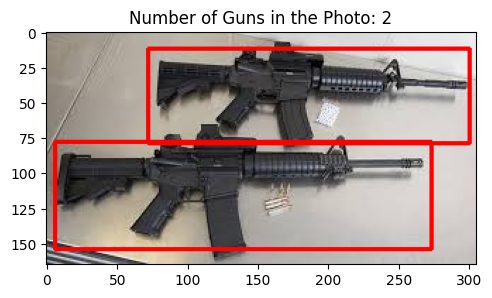

In [4]:
# Display a sample annotated image
imgshow(119, title="Number of Guns in the Photo: ")

## 🧹 **Dataset Preparation**
### 📦 **5. Custom Dataset Class <a id="5-custom-dataset-class"></a>**

In [5]:
# -------------------------------------------------------------------
# 📦 Custom Dataset Class: Gun_Data
# -------------------------------------------------------------------
class Gun_Data(Dataset):
    """
    Custom PyTorch Dataset for gun detection.

    Loads images and their corresponding bounding box coordinates
    for object detection tasks using Faster R-CNN. Each image is
    normalised and converted to a tensor, while labels are parsed
    from text files containing bounding box coordinates.

    Parameters
    ----------
    root : str
        Root directory containing 'Images/' and 'Labels/' folders.

    Returns
    -------
    Tuple[torch.Tensor, dict]
        Image tensor and target dictionary containing:
        - boxes (Tensor): Bounding box coordinates
        - area (Tensor): Area of each box
        - image_id (Tensor): Unique image index
        - labels (Tensor): Class labels
    """

    def __init__(self, root: str):
        # Define image and label folder paths
        self.image_path = os.path.join(root, "Images")
        self.labels_path = os.path.join(root, "Labels")

        # Retrieve and sort all image filenames
        self.img_name = sorted(os.listdir(self.image_path))

        # Retrieve and sort all label filenames
        self.label_name = sorted(os.listdir(self.labels_path))

    def __getitem__(self, idx: int):
        """
        Load a single image and its corresponding annotation.

        Parameters
        ----------
        idx : int
            Index of the image to retrieve.

        Returns
        -------
        Tuple[torch.Tensor, dict]
            The image tensor and its associated bounding box data.
        """

        # Get full image path
        image_path = os.path.join(self.image_path, self.img_name[idx])

        # Read image using OpenCV
        image = cv2.imread(image_path)

        # Convert BGR ➜ RGB colour format and cast to float
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)

        # Normalise pixel values and convert to tensor
        img_res = torch.as_tensor(img_rgb / 255).permute(2, 0, 1)

        # Construct corresponding label filename
        label_name = self.img_name[idx].replace(".jpeg", ".txt")
        label_path = os.path.join(self.labels_path, label_name)

        # Open label file and read bounding box data
        with open(label_path, "r") as label_file:
            # Read number of bounding boxes
            l_count = int(label_file.readline())

            # Parse bounding box coordinates
            boxes = [list(map(int, label_file.readline().split())) for _ in range(l_count)]

        # Compute area for each bounding box
        areas = [(b[2] - b[0]) * (b[3] - b[1]) for b in boxes]

        # Assign all boxes the label '1' (gun class)
        labels = [1] * len(boxes)

        # Construct target dictionary for detection model
        target = {
            "boxes": torch.as_tensor(boxes, dtype=torch.float32),
            "area": torch.as_tensor(areas, dtype=torch.float32),
            "image_id": torch.tensor([idx]),
            "labels": torch.as_tensor(labels, dtype=torch.int64)
        }

        # Move image tensor to device
        img_res = img_res.to(device)

        # Move all tensor fields in target dictionary to device
        for key, val in target.items():
            if isinstance(val, torch.Tensor):
                target[key] = val.to(device)

        # Return processed image and target dictionary
        return img_res, target

    def __len__(self) -> int:
        """
        Return the total number of images in the dataset.

        Returns
        -------
        int
            Number of images available for training or validation.
        """

        # Return dataset length
        return len(self.img_name)

## 🧠 **Model Definition & Training**
### 🧩 **6. Model Class (Faster R-CNN) <a id="6-model-class-faster-rcnn"></a>**

In [6]:
# -------------------------------------------------------------------
# 🧠 Model Wrapper: Faster R-CNN for Gun Detection
# -------------------------------------------------------------------
class Model:
    """
    Wrapper class for Faster R-CNN with configurable output classes.

    This class handles model creation, compilation with an optimiser,
    and training for object detection on the gun dataset.

    Parameters
    ----------
    num_classes : int
        Number of output classes including background (e.g., 2 for
        background + gun).

    Attributes
    ----------
    model : torchvision.models.detection.FasterRCNN
        The instantiated Faster R-CNN model.
    optimizer : torch.optim.Optimizer
        Optimiser used during training (set via `compiler` method).
    """

    def __init__(self, num_classes: int):
        # Store number of output classes
        self.num_classes = num_classes

        # Create a new Faster R-CNN model
        self.model = self.create_model()

    def create_model(self) -> FasterRCNN:
        """
        Initialise a pretrained Faster R-CNN model with ResNet-50 backbone.

        The classifier head is replaced with a new one configured
        for the desired number of output classes.

        Returns
        -------
        FasterRCNN
            A PyTorch Faster R-CNN model ready for training.
        """

        # Load pretrained Faster R-CNN with Feature Pyramid Network
        model = fasterrcnn_resnet50_fpn(pretrained=True)

        # Get input features for classification layer
        in_features = model.roi_heads.box_predictor.cls_score.in_features

        # Replace classification head to match custom number of classes
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, self.num_classes)

        # Return configured model
        return model

    def compiler(self, optimizer: optim.Optimizer) -> None:
        """
        Attach an optimiser to the model before training.

        Parameters
        ----------
        optimizer : torch.optim.Optimizer
            The optimiser instance to use for training (e.g. Adam).
        """

        # Assign optimiser to the model
        self.optimizer = optimizer

    def train(self, train_data: DataLoader, val_data: DataLoader, num_epoch: int = 30) -> None:
        """
        Train the Faster R-CNN model for a specified number of epochs.

        Parameters
        ----------
        train_data : torch.utils.data.DataLoader
            DataLoader containing training images and annotations.
        val_data : torch.utils.data.DataLoader
            DataLoader containing validation images and annotations.
        num_epoch : int, default=30
            Number of training epochs to perform.

        Returns
        -------
        None
            Prints training loss per epoch.
        """

        # Move model to appropriate device (GPU or CPU)
        self.model.to(device)

        # Iterate through epochs
        for epoch in tqdm(range(num_epoch), desc="Training Progress"):
            # Track cumulative loss for the epoch
            train_loss = 0.0

            # Set model to training mode
            self.model.train()

            # Iterate through training batches
            for imgs, targets in train_data:
                # Forward pass to compute detection losses
                losses = self.model(imgs, targets)

                # Sum up all loss components
                loss = sum(losses.values())

                # Reset optimiser gradients
                self.optimizer.zero_grad()

                # Backpropagate loss
                loss.backward()

                # Update model weights
                self.optimizer.step()

                # Accumulate total loss
                train_loss += loss.item()

            # Print average loss after each epoch
            print(f"Epoch {epoch + 1}/{num_epoch} | Train Loss: {train_loss:.4f}")

### ⚖️ **7. DataLoaders & Training Loop <a id="7-dataloaders--training-loop"></a>**

In [7]:
# -------------------------------------------------------------------
# ⚖️ Dataset Splits, DataLoaders, and Model Training
# -------------------------------------------------------------------
"""
Initialise dataset splits, DataLoaders, and begin model training.
"""

def collate_fn(batch):
    """
    Custom collate function for variable-sized target lists.

    Ensures batches of images and targets can be zipped correctly
    when the number of bounding boxes differs between images.

    Parameters
    ----------
    batch : list
        List of tuples (image_tensor, target_dict) from Dataset.

    Returns
    -------
    Tuple
        Tuple of two lists: (images, targets).
    """
    # Unzip images and targets into separate tuples
    return tuple(zip(*batch))


# -------------------------------------------------------------------
# 📂 Dataset and DataLoader Setup
# -------------------------------------------------------------------

# Load dataset from Kaggle input directory
dataset = Gun_Data("/kaggle/input/guns-object-detection/")

# Calculate train and validation sizes (80/20 split)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Randomly split dataset into training and validation subsets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader for training (shuffle enabled)
train_loader = DataLoader(
    train_dataset,
    batch_size=3,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

# Create DataLoader for validation (no shuffle)
val_loader = DataLoader(
    val_dataset,
    batch_size=3,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)


# -------------------------------------------------------------------
# ⚙️ Model Initialisation, Optimiser, and Training
# -------------------------------------------------------------------

# Instantiate Faster R-CNN wrapper for 2 classes (background + gun)
rcnn = Model(num_classes=2)

# Extract model object from wrapper
model = rcnn.model

# Define optimiser (Adam with low learning rate)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Compile model with optimiser
rcnn.compiler(optimizer)

# Begin model training for 30 epochs
rcnn.train(train_loader, val_loader, num_epoch=30)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 207MB/s] 


Training Progress:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30 | Train Loss: 22.3328
Epoch 2/30 | Train Loss: 18.2448
Epoch 3/30 | Train Loss: 16.1029
Epoch 4/30 | Train Loss: 12.1962
Epoch 5/30 | Train Loss: 10.2925
Epoch 6/30 | Train Loss: 9.4750
Epoch 7/30 | Train Loss: 8.2348
Epoch 8/30 | Train Loss: 7.9174
Epoch 9/30 | Train Loss: 7.1917
Epoch 10/30 | Train Loss: 6.4934
Epoch 11/30 | Train Loss: 6.2330
Epoch 12/30 | Train Loss: 5.6872
Epoch 13/30 | Train Loss: 5.9582
Epoch 14/30 | Train Loss: 5.6600
Epoch 15/30 | Train Loss: 4.7930
Epoch 16/30 | Train Loss: 4.4789
Epoch 17/30 | Train Loss: 4.6912
Epoch 18/30 | Train Loss: 4.6584
Epoch 19/30 | Train Loss: 4.1170
Epoch 20/30 | Train Loss: 3.7444
Epoch 21/30 | Train Loss: 3.8648
Epoch 22/30 | Train Loss: 3.8537
Epoch 23/30 | Train Loss: 3.4526
Epoch 24/30 | Train Loss: 3.5883
Epoch 25/30 | Train Loss: 3.7680
Epoch 26/30 | Train Loss: 4.0319
Epoch 27/30 | Train Loss: 3.5829
Epoch 28/30 | Train Loss: 3.3647
Epoch 29/30 | Train Loss: 3.4012
Epoch 30/30 | Train Loss: 3.2883


## 🧪 **Inference & Evaluation**
### 🔍 **8. Prediction Helpers <a id="8-prediction-helpers"></a>**

In [8]:
# -------------------------------------------------------------------
# 🧩 Utility Functions: Inference, NMS, and Image Conversion
# -------------------------------------------------------------------
"""
Utility functions for model inference, Non-Maximum Suppression (NMS),
and converting image tensors between PyTorch and PIL formats.
"""

def test(data: Dataset, number: int = random.randint(1, 334)):
    """
    Run a forward pass for a single image to obtain predictions.

    Parameters
    ----------
    data : torch.utils.data.Dataset
        The dataset containing images and labels.
    number : int, optional
        Index of the image to test. Defaults to a random sample.

    Returns
    -------
    Tuple[list[dict], dict, torch.Tensor]
        A tuple containing:
        - predictions : list of dicts (model output)
        - target : ground truth dictionary
        - img : image tensor input
    """

    # Retrieve one image and its target from the dataset
    img, target = data[number]

    # Switch model to evaluation mode
    model.eval()

    # Perform forward pass to get predictions
    predictions = model([img])

    # Move prediction tensors to the same device (GPU or CPU)
    predictions = [{k: v.to(device) for k, v in t.items()} for t in predictions]

    # Return predictions, ground truth, and image tensor
    return predictions, target, img


def apply_nms(orig_predictions: dict, iou_threshold: float = 0.5) -> dict:
    """
    Apply Non-Maximum Suppression (NMS) to remove overlapping boxes.

    Parameters
    ----------
    orig_predictions : dict
        Original predictions containing boxes, scores, and labels.
    iou_threshold : float, default=0.5
        Intersection over Union (IoU) threshold for suppression.

    Returns
    -------
    dict
        Filtered predictions with redundant boxes removed.
    """

    # Select indices to keep using NMS based on IoU threshold
    keep = torchvision.ops.nms(
        orig_predictions["boxes"],
        orig_predictions["scores"],
        iou_threshold
    )

    # Retain only the non-suppressed predictions
    final_predictions = {k: v[keep] for k, v in orig_predictions.items()}

    # Return filtered prediction dictionary
    return final_predictions


def torch_to_pil(img: torch.Tensor) -> Image.Image:
    """
    Convert a PyTorch tensor image to a PIL image.

    Parameters
    ----------
    img : torch.Tensor
        Image tensor to be converted (C x H x W).

    Returns
    -------
    PIL.Image.Image
        Converted image in RGB format.
    """

    # Convert tensor to PIL Image
    pil_image = torchtrans.ToPILImage()(img)

    # Ensure colour format is RGB
    pil_image = pil_image.convert("RGB")

    # Return converted image
    return pil_image

### 🎯 **9. Visualise Predictions <a id="9-visualise-predictions"></a>**

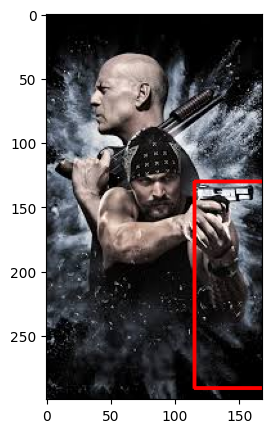

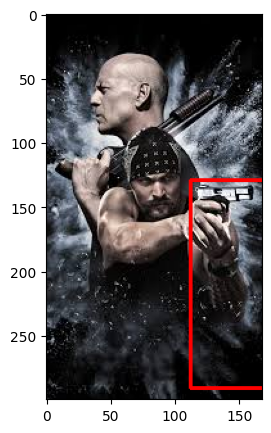

In [9]:
# -------------------------------------------------------------------
# 🎯 Visualisation Functions: Display Bounding Boxes
# -------------------------------------------------------------------
"""
Functions to display bounding boxes for both ground-truth targets
and model predictions using OpenCV and Matplotlib.
"""

def plot_img_bbox(img: Image.Image, target: dict, size: int = 5) -> None:
    """
    Plot bounding boxes on an image.

    Converts a PIL image to OpenCV format, draws red rectangles
    around detected objects, and displays the result using Matplotlib.

    Parameters
    ----------
    img : PIL.Image.Image
        Image on which to draw bounding boxes.
    target : dict
        Dictionary containing bounding box coordinates under 'boxes'.
    size : int, default=5
        Base figure size for Matplotlib visualisation.

    Returns
    -------
    None
        Displays the image with overlaid bounding boxes.
    """

    # Convert PIL image to OpenCV BGR format
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    # Loop through all bounding boxes in target
    for box in target["boxes"]:
        # Extract box coordinates as integers
        x, y, width, height = box.tolist()

        # Draw rectangle (red, thickness = 2)
        cv2.rectangle(
            img_cv,
            (int(x), int(y)),
            (int(x + width), int(y + height)),
            (0, 0, 255),
            2
        )

    # Calculate aspect ratio for proper display scaling
    aspect_ratio = img_cv.shape[0] / img_cv.shape[1]

    # Create Matplotlib figure adjusted by aspect ratio
    plt.figure(figsize=(size + aspect_ratio, size))

    # Convert BGR ➜ RGB before plotting
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))

    # Show final image with bounding boxes
    plt.show()


# -------------------------------------------------------------------
# 🧩 Run inference and visualise results
# -------------------------------------------------------------------

# Generate predictions for one sample image
predictions, target, img = test(dataset, number=1)

# Apply Non-Maximum Suppression to clean overlapping boxes
nms_prediction = apply_nms(predictions[0], iou_threshold=0.7)

# Convert Torch tensor image to PIL and plot ground-truth boxes
plot_img_bbox(torch_to_pil(img), target)

# Plot model predictions after NMS
plot_img_bbox(torch_to_pil(img), nms_prediction)